In [1]:
import os
import numpy as np
from pathlib import Path
import json
import collections
import torch
import torch.utils.data
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.patheffects as patheffects

In [2]:
class KCocoDatasetWithMaxOneBB(torch.utils.data.Dataset):    
    def __init__(self, root, jsonname, transforms = None):
        self.root = root
        self.PATH = Path(root)        
        self.jsonname = jsonname
        self.transforms =  transforms                
        
        trn_j = json.load( (self.PATH/jsonname).open() )        
        self.images = trn_j['images']
        
        self.cats =  {o['id']:o['name'] for o in trn_j['categories']}
        self.trn_fns = {o['id']:o['file_name'] for o in trn_j['images']}
        self.trn_ids = [o['id'] for o in trn_j['images']]                
        
        
        self.trn_anno = collections.defaultdict( lambda:[] )
        for o in trn_j['annotations']:
            if not o['ignore']:
                bb = o['bbox']                
                self.trn_anno[o['image_id']].append((bb, o['category_id'], o['area'], o['iscrowd']))        
        
        self.trn_onemaxbb = {}        
        for o in self.trn_anno:            
            nAreaMax = -1
            for t in self.trn_anno[o]:
                if nAreaMax < t[2] :                                        
                    self.trn_onemaxbb[ o ] =  t                    
                    nAreaMax = t[2]
                    
    def __getitem__(self, idx):
        img_id = self.trn_ids[idx]
        img_name = self.trn_fns[img_id]
        #print("img_id", img_id)
        #print("img_name", img_name)
        JPEGS = 'VOCdevkit/VOC2007/JPEGImages'
        img = Image.open( self.PATH/JPEGS/img_name ).convert("RGB")

        boxes = []
        labels = []
        areas = []
        iscrowds = []
        onemaxbbs = []
        onemaxlabels = []
        
        for o in self.trn_anno[img_id]:        
            x = o[0][0]
            y = o[0][1]
            width = o[0][2]
            height = o[0][3]            
            boxes.append( [x, y, x + width -1, y + height -1] )
            
            labels.append(o[1])
            areas.append(o[2])
            iscrowds.append(o[3])
            
        aa = self.trn_onemaxbb[img_id][0]    
        onemaxbbs.append( [ aa[0], aa[1], aa[0] + aa[2] - 1, aa[1] + aa[3] -1 ] )    
        onemaxlabels.append( [self.trn_onemaxbb[img_id][1]] )
        
            
        target = {}              
        
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        areas = torch.as_tensor(areas, dtype=torch.float32)
        iscrowds = torch.as_tensor(iscrowds, dtype=torch.int64)
        onemaxbs = torch.as_tensor(onemaxbbs, dtype=torch.float32)       
        onemaxlabels = torch.as_tensor(onemaxlabels, dtype=torch.int64)
        image_id = torch.tensor([img_id])        
        
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = areas
        target["iscrowd"] = iscrowds       
        target["onemaxbb"] = onemaxbbs
        target["onemaxlabel"] = onemaxlabels
        target["onemaxlabelraw"] = self.cats[ onemaxlabels[0].item() ]
        
        
        if self.transforms is not None:
            img, target = self.transforms(img, target)
        return img, target
    
    def __len__(self):
        return len( self.images)
    
                        

In [3]:
def bb_hw(a): return np.array([a[0],a[1],a[2]-a[0]+1,a[3]-a[1]+1])

def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

def draw_rect(ax, b, edgecolor='white'):    
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor=edgecolor, lw=2))    
    draw_outline(patch, 4)

def draw_text(ax, xy, txt, sz=14, color='white'):
    text = ax.text(*xy, txt,
        verticalalignment='top', color=color, fontsize=sz, weight='bold')
    draw_outline(text, 1)

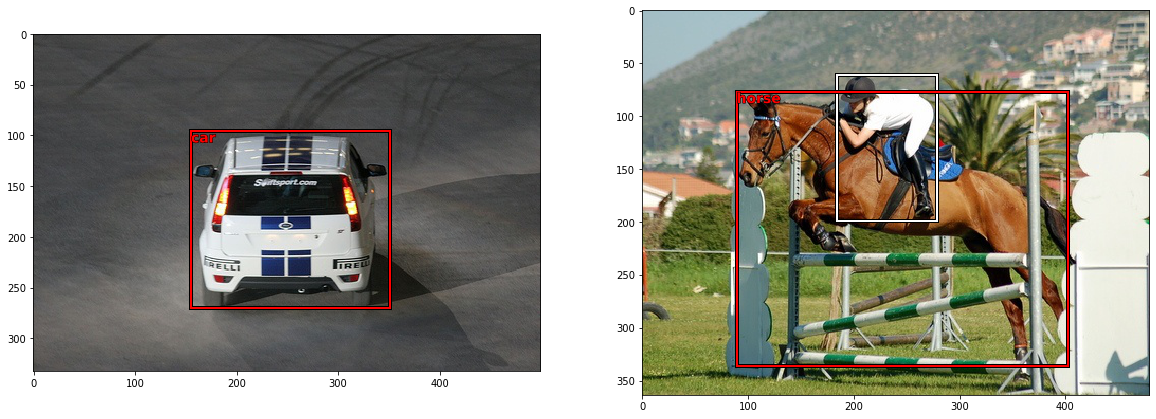

In [4]:
dataset = KCocoDatasetWithMaxOneBB('data/pascal', 'pascal_train2007.json', None)
len(dataset)

nNum = 2
nCol = 2
fig, axes = plt.subplots( int(nNum / nCol), nCol, figsize=(20,60))
for i, ax in enumerate( axes.flatten() , 0):
    ax.imshow( dataset[i][0]  )    
    for box in  dataset[i][1]['boxes']:
        draw_rect(ax,bb_hw( box )  )
    box = dataset[i][1]['onemaxbb'][0]
    labelraw = dataset[i][1]['onemaxlabelraw']
    draw_rect(ax,bb_hw( box ) , 'red' )
    draw_text(ax, bb_hw( box )[:2], labelraw, color='red' )
    
    #print("dataset[i][1]", dataset[i][1])    
